In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler.Strict

import Control.Monad
import Data.List
import Data.Ord
import Control.Arrow (first)
import Data.Text (pack, Text)
import Numeric.Log
import Control.Arrow (second)

:l ../plotting.hs

# Sampling

Before discussing inference, we should understand how to sample from models. This notebook explains how to do that.

## Discrete distribution
We'll start with a very simple model, namely:

In [2]:
model :: MonadSample m => m Bool
model = bernoulli 0.7

To take a sample, do:

In [3]:
sampler model

True

Or with a fixed seed:

In [4]:
sampleIOfixed model

True

To take multiple samples, you could rerun `sampler` many times, but it's somewhat more in the probabilistic programming spirit to instead define a distribution over multiple draws from `model` and then just sample once, as follows:

In [5]:
multipleDraws :: MonadSample m => m [Bool]
multipleDraws = replicateM 10 model

draws <- sampler multipleDraws

draws

[False,False,True,True,True,True,False,False,True,True]

We can write a function to convert a list of samples to an empirical distribution, like so:

In [6]:
emp = toEmpirical draws :: [(Bool, Double)]

emp

[(True,0.6),(False,0.4)]

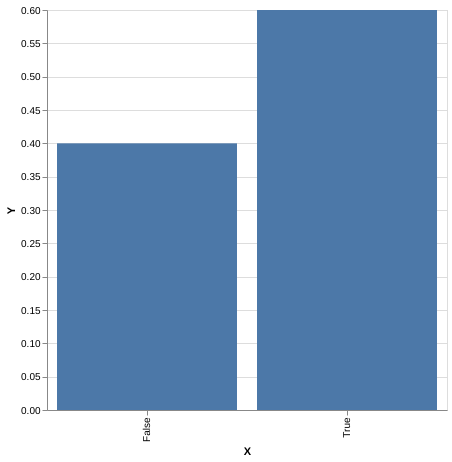

In [7]:
plot $ first (pack . show) <$> emp

In fact, we could lean even further into the spirit of probabilistic programming, and transform `model` into a distribution over plots, and sample from that:

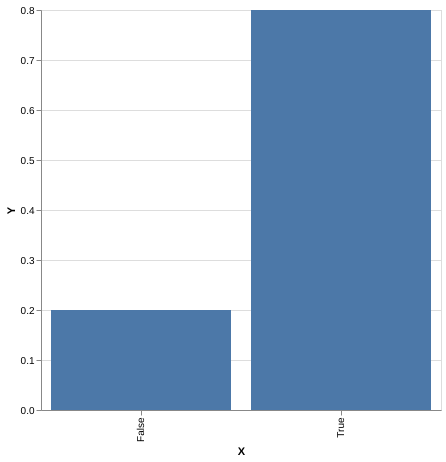

In [8]:
distributionOverPlots :: MonadSample m => m VegaLiteLab -- the type of plots
distributionOverPlots = plot . fmap (first (pack . show)) . toEmpirical <$> replicateM 10 model

sampler distributionOverPlots


## Continuous distributions

Consider normal distribution:

In [9]:
model2 :: MonadSample m => m Double
model2 = normal 0 1

Sampling is no different to before:

In [10]:
sampler model2

0.3592224664069264

And as before, to obtain multiple draws:

In [11]:
multipleDraws2 :: MonadSample m => m [Double]
multipleDraws2 = replicateM 10 model2

draws2 <- sampler multipleDraws2

draws2

[1.3111415523379397,0.9285221888934839,0.5647181975063041,-2.5207045713889786,0.2717327812615383,0.8284965754721946,1.1938372784308815,-1.3180092302797952,1.2621963936179572,-0.9537504738411796]

We'd like to view a histogram of samples, which in the limit of many samples should tend to the PDF of a normal distribution.

Again, we could apply a histogram to the list of samples:

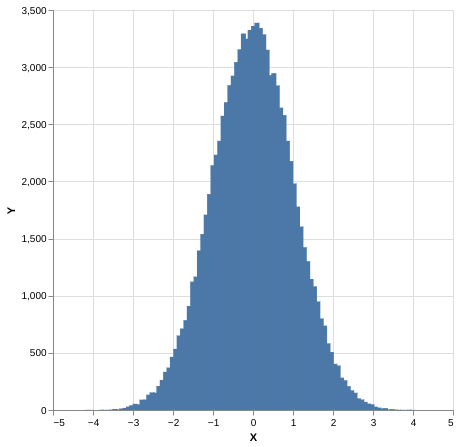

In [12]:
samples <- sampler $ replicateM 100000 (weighted model2)
plot . histogramToList . histogram 100 $ samples


but it's nicer to apply a `histogram` function to multiple draws to define a distribution over histograms from which we'll sample. 

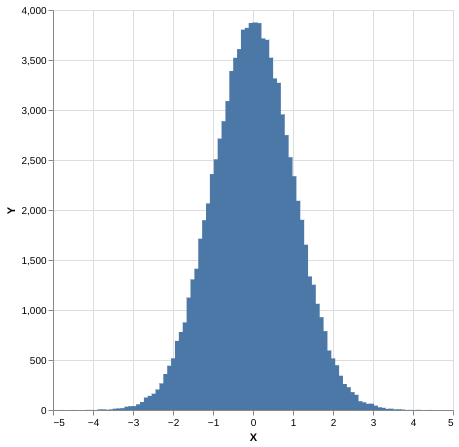

In [13]:
sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 (weighted model2)

Mixture model:

In [14]:
model3 = do
    p <- bernoulli 0.7
    if p then normal 0 1 else normal 3 1

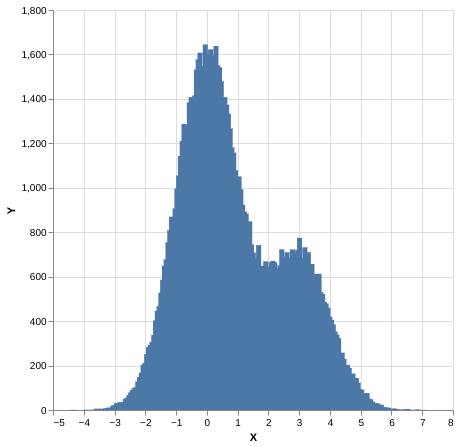

In [15]:
sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model3)


# Weighted Sampling

For models with factor statements, we cannot just sample. For example, consider:

In [16]:
model4 = do
    p <- bernoulli 0.7
    out <- if p then normal 0 1 else normal 3 1
    condition (out > 0)
    return out


We could ignore the `condition` statement using `unweighted`, as in:

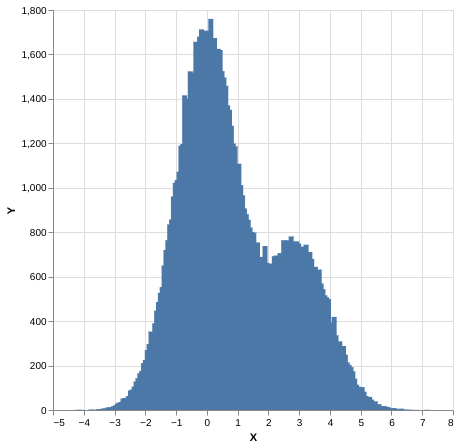

In [17]:
sampler . unweighted $ plot . histogramToList . histogram 200 <$> replicateM 100000 (weighted $ unweighted model4)


But obviously, we'd like to take samples from the posterior. We can do so as follows:

In [18]:
draws4 <- sampler $ replicateM 10 $ weighted model4
draws4

[(4.232362859035877,1.0),(1.4330116837253835,1.0),(-1.5198436166386977,0.0),(0.7820884976970929,1.0),(0.234799069539591,1.0),(-0.15931269424875988,0.0),(1.3462776980762363,1.0),(-1.3679904436271806,0.0),(3.8560873527526787,1.0),(-1.4459479761197156,0.0)]

Here, we use `weighted` to convert `model4` into a distribution over pairs of numbers and their weights. We then sample from that. To view 

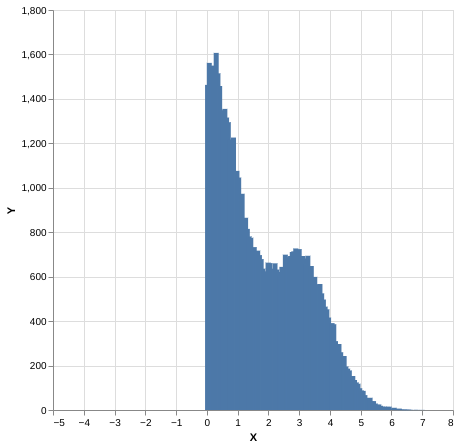

In [19]:
sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model4)

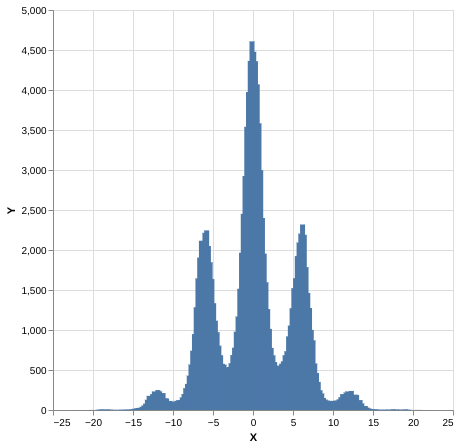

In [20]:
model5 :: MonadInfer m => m Double
model5 = do
    x <- normal 0 5
    (factor . Exp) (cos x)
    return x

sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model5)